# Simple Trading Algorithm


In [108]:
import ccxt
import pandas as pd
import time
from datetime import datetime

exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1h'
limit = 1000  
max_candles = 50000

all_data = []
since = exchange.parse8601('2020-01-01T00:00:00Z') 

while len(all_data) < max_candles:
    print(f"Fetching candles since {datetime.utcfromtimestamp(since / 1000)}...")
    candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)

    if not candles:
        print("No more data returned.")
        break

    all_data += candles
    since = candles[-1][0] + 1 
    time.sleep(exchange.rateLimit / 1000)  

# Převeď na DataFrame
df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(f"Staženo: {len(df)} svíček")



Fetching candles since 2020-01-01 00:00:00...
Fetching candles since 2020-02-11 16:00:00.001000...
Fetching candles since 2020-03-24 14:00:00.001000...
Fetching candles since 2020-05-05 08:00:00.001000...
Fetching candles since 2020-06-16 00:00:00.001000...
Fetching candles since 2020-07-27 19:00:00.001000...
Fetching candles since 2020-09-07 11:00:00.001000...
Fetching candles since 2020-10-19 03:00:00.001000...
Fetching candles since 2020-11-29 19:00:00.001000...
Fetching candles since 2021-01-10 17:00:00.001000...
Fetching candles since 2021-02-21 10:00:00.001000...
Fetching candles since 2021-04-04 03:00:00.001000...
Fetching candles since 2021-05-16 00:00:00.001000...
Fetching candles since 2021-06-26 16:00:00.001000...
Fetching candles since 2021-08-07 08:00:00.001000...
Fetching candles since 2021-09-18 04:00:00.001000...
Fetching candles since 2021-10-29 22:00:00.001000...
Fetching candles since 2021-12-10 14:00:00.001000...
Fetching candles since 2022-01-21 06:00:00.001000...


In [125]:
from ta.momentum import RSIIndicator

rsi = RSIIndicator(close=df['close'], window=14)
df['rsi'] = rsi.rsi()

window = 500
mult = 1.5

# Bollinger Bands
df['sma'] = df['close'].rolling(window=window).mean()
df['std'] = df['close'].rolling(window=window).std()
df['upper_band'] = df['sma'] + mult * df['std']
df['lower_band'] = df['sma'] - mult * df['std']

df['position'] = 0
entry_cond = (df['close'] < df['lower_band']) & (df['rsi'] < 25)
exit_cond = (df['rsi'] > 50)

df.loc[entry_cond, 'position'] = 1
df.loc[exit_cond, 'position'] = 0
df['position'] = df['position'].ffill()



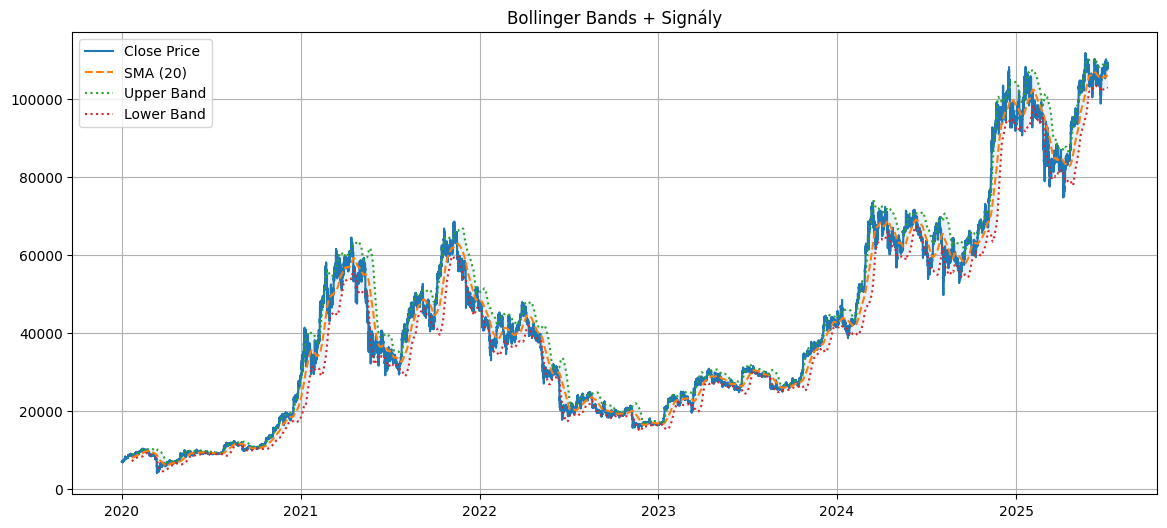

In [126]:
plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Close Price')
plt.plot(df['sma'], label='SMA (20)', linestyle='--')
plt.plot(df['upper_band'], label='Upper Band', linestyle=':')
plt.plot(df['lower_band'], label='Lower Band', linestyle=':')
plt.fill_between(df.index, df['lower_band'], df['upper_band'], alpha=0.1)
plt.title('Bollinger Bands + Signály')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
# Profit from price
df['returns'] = df['close'].pct_change()

# Profit when holding
df['strategy_returns'] = df['returns'] * df['position']

# Evolvement of total equity
df['equity'] = (1 + df['strategy_returns']).cumprod()

# Buy and hold strategy comparison
df['buy_hold'] = (1 + df['returns']).cumprod()


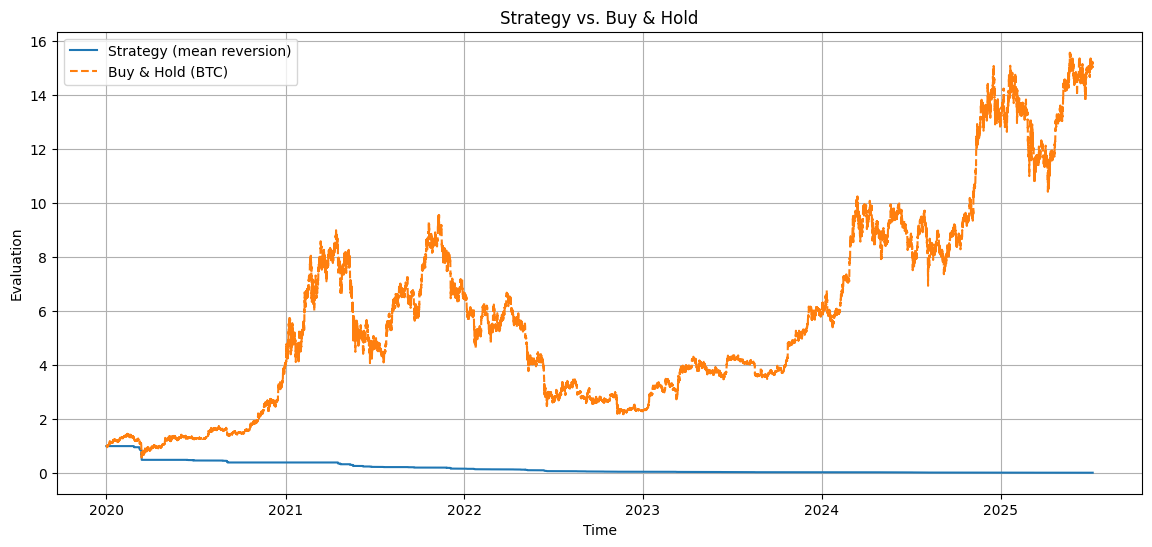

In [128]:
plt.figure(figsize=(14, 6))
plt.plot(df['equity'], label='Strategy (mean reversion)')
plt.plot(df['buy_hold'], label='Buy & Hold (BTC)', linestyle='--')
plt.title('Strategy vs. Buy & Hold')
plt.xlabel('Time')
plt.ylabel('Evaluation')
plt.grid(True)
plt.legend()
plt.show()


In [129]:
# Total profit
total_return = df['equity'].iloc[-1] - 1
print(f"Celkový výnos strategie: {total_return:.2%}")

# Sharpe ratio (hourly data, without nonrisk rate)
sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * (24 ** 0.5)
print(f"Sharpe ratio: {sharpe:.2f}")


Celkový výnos strategie: -98.64%
Sharpe ratio: -0.22


In [134]:
### EMA

short_window = 10
long_window = 100


df['ema_short'] = df['close'].ewm(span=short_window, adjust=False).mean()
df['ema_long'] = df['close'].ewm(span=long_window, adjust=False).mean()


In [135]:

df['position'] = 0
df.loc[df['ema_short'] > df['ema_long'], 'position'] = 1
df['position'] = df['position'].ffill()


In [136]:
# Výnosy
df['returns'] = df['close'].pct_change()
df['strategy_returns'] = df['returns'] * df['position']
df['equity'] = (1 + df['strategy_returns']).cumprod()
df['buy_hold'] = (1 + df['returns']).cumprod()


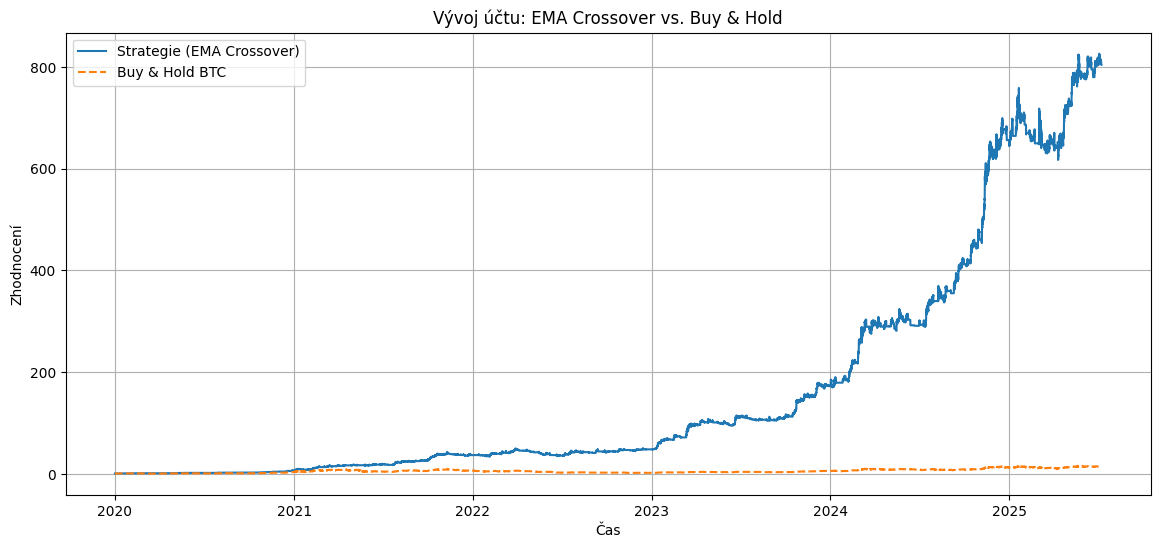

📈 Výnos strategie: 80296.63%
⚖️ Sharpe ratio: 0.16


In [137]:
plt.figure(figsize=(14, 6))
plt.plot(df['equity'], label='Strategie (EMA Crossover)')
plt.plot(df['buy_hold'], label='Buy & Hold BTC', linestyle='--')
plt.title('Vývoj účtu: EMA Crossover vs. Buy & Hold')
plt.xlabel('Čas')
plt.ylabel('Zhodnocení')
plt.grid(True)
plt.legend()
plt.show()

# Výnos + Sharpe
total_return = df['equity'].iloc[-1] - 1
sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * (24 ** 0.5)

print(f"📈 Výnos strategie: {total_return:.2%}")
print(f"⚖️ Sharpe ratio: {sharpe:.2f}")
